# Using neural networks to recognize handwritten numbers

In [1]:
!pip install matplotlib 
!pip install sklearn 
!pip install tensorflow

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1320 sha256=98e1f442dd65b4f364559051276c75f8b0103e7956746dc036fddd554004d91b
  Stored in directory: c:\users\bokan\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
^C


Import modules and libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
from typing import List
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

MNIST is a huge database of handwritten numbers that is used as a benchmark and point of acquaintance with machine learning and image processing systems. It is ideal to focus specifically on the learning process of the neural network.

### Goal:
Train the system classify each with the appropriate label (shown by the number). Using a dataset of 60,000 handwritten digit images (represented as 28x28 pixel images, each grayscale from 0 to 255).

### Data set
A dataset of training and test data, but for the sake of simplicity, this will only be a training dataset. Load it like this:

In [9]:
%%bash

rm -Rf train-images-idx3-ubyte.gz
rm -Rf train-labels-idx1-ubyte.gz
wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

Process is interrupted.


There are 10 digits: (0-9), so each label must be a digit from 0 to 9. The loaded file, train-labels-idx1-ubyte.gz, encodes the labels as follows:

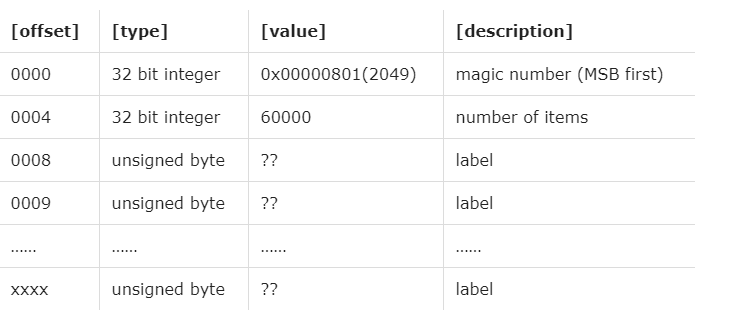

### Reading labels

Label values from 0 to 9.

The first 8 bytes (or the first 2 32-bit integers) can be skipped because they contain the metadata files required for low-level programming languages. To parse a file, you need to do the following operations:

1.Open file with gzip library so it can be unpacked

2.Read the entire byte array into memory

3.Skip first 8 bytes

4.Loop over each byte and convert it to an integer

In [10]:
with gzip.open('train-labels-idx1-ubyte.gz') as train_labels:
    data_from_train_file = train_labels.read()

# skip first 8 bytes
label_data = data_from_train_file[8:]
assert len(label_data) == 60000

# Convert each byte to an integer.
# This will be a number between 0 and 9
labels = [int(label_byte) for label_byte in label_data]
assert min(labels) == 0 and max(labels) == 9
assert len(labels) == 60000

### Reading images
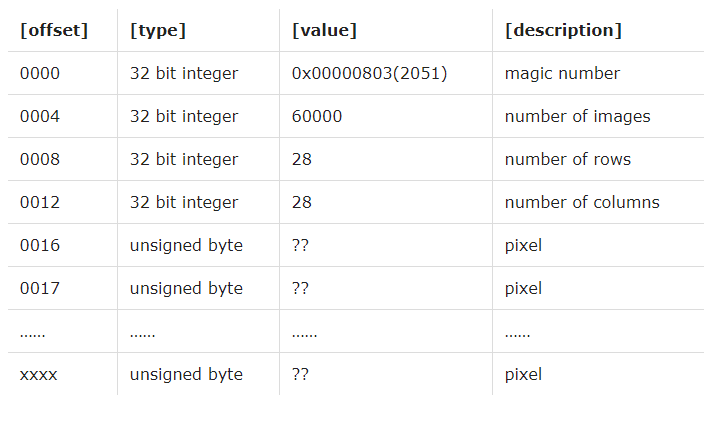



Reading images is slightly different from reading labels. The first 16 bytes contain already known metadata. You can skip them and go directly to reading the images. Each of them is represented as a 28 * 28 array of unsigned bytes. All it takes is to read one image at a time and store them in an array.

In [11]:
SIZE_OF_ONE_IMAGE = 28 ** 2
images = []

# Looping through the training file and reading one image at a time
with gzip.open('train-images-idx3-ubyte.gz') as train_images:
    train_images.read(4 * 4)
    ctr = 0
    for _ in range(60000):
        image = train_images.read(size=SIZE_OF_ONE_IMAGE)
        assert len(image) == SIZE_OF_ONE_IMAGE
        
        # Convert to NumPy
        image_np = np.frombuffer(image, dtype='uint8') / 255
        images.append(image_np)

images = np.array(images)
images.shape

(60000, 784)

There are 60,000 images in the list. Each of them is represented by a bit vector of size SIZE_OF_ONE_IMAGE. Let's try to plot an image using the matplotlib library

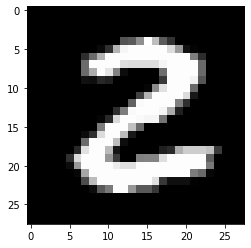

In [12]:
def plot_image(pixels: np.array):
    plt.imshow(pixels.reshape((28, 28)), cmap='gray')
    plt.show()

plot_image(images[25])

### Encoding image labels using One-hot encoding

In [13]:
labels_np = np.array(labels).reshape((-1, 1))

encoder = OneHotEncoder(categories='auto')
labels_np_onehot = encoder.fit_transform(labels_np).toarray()

labels_np_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

The input data and vector output have been successfully created, which will go to the input and output layers of the neural network. The input vector at index i will correspond to the output vector at index i.

Input and Output:

In [14]:
labels_np_onehot[999]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Input and Output:

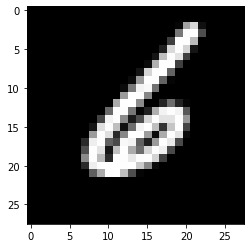

In [16]:
plot_image(images[999])

In the example above, you can clearly see that the image with index 999 represents the digit 6. The vector associated with it contains 10 digits (since there are 10 labels), and the digit with index 6 is 1. This means that the label is correct.

### Dividing the dataset into training and test

To check that the neural network has been trained correctly, we take a certain percentage of the training set (60,000 images) and use it for testing purposes.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_np_onehot)
print(y_train.shape)
print(y_test.shape)

(45000, 10)
(15000, 10)


Here you can see that the entire set of 60,000 images is split into two: one with 45,000 and the other with 15,000 images.

### Neural network training with Keras

In [19]:
model = keras.Sequential()
model.add(keras.layers.Dense(input_shape=(SIZE_OF_ONE_IMAGE,), units=128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


To train the neural network, let's execute this code.

In [20]:
model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
352/352 [==============================] - 3s 5ms/step - loss: 1.3658 - accuracy: 0.6672
Epoch 2/20
352/352 [==============================] - 1s 3ms/step - loss: 0.6416 - accuracy: 0.8532
Epoch 3/20
352/352 [==============================] - 1s 4ms/step - loss: 0.4905 - accuracy: 0.8751
Epoch 4/20
352/352 [==============================] - 1s 3ms/step - loss: 0.4270 - accuracy: 0.8863
Epoch 5/20
352/352 [==============================] - 1s 2ms/step - loss: 0.3900 - accuracy: 0.8942
Epoch 6/20
352/352 [==============================] - 1s 2ms/step - loss: 0.3651 - accuracy: 0.8994
Epoch 7/20
352/352 [==============================] - 1s 3ms/step - loss: 0.3468 - accuracy: 0.9035
Epoch 8/20
352/352 [==============================] - 2s 4ms/step - loss: 0.3320 - accuracy: 0.9072
Epoch 9/20
352/352 [==============================] - 1s 3ms/step - loss: 0.3199 - accuracy: 0.9101
Epoch 10/20
352/352 [==============================] - 1s 3ms/step - loss: 0.3094 - accuracy: 0.9137

Проверяем точность на тренировочных данных.

In [21]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 2s 1ms/step - loss: 0.2604 - accuracy: 0.9261


[0.26039621233940125, 0.9261333346366882]

### Let's see the results

So you have trained a neural network to predict handwritten numbers with an accuracy of better than 90%. Let's check it using the image from the test suite.

Let's take a random image - a picture with index 1010. Take the predicted label (in this case - 8, because the number 1 is in the fifth position)

In [22]:
y_test[1010]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

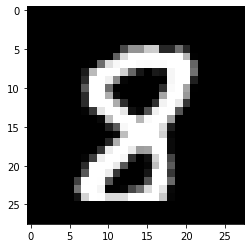

In [23]:
plot_image(X_test[1010])

Understanding the output of the softmax activation layer
Let's run the figure through the neural network and see what output it predicts.

Inputs:

In [24]:
predicted_results = model.predict(X_test[1010].reshape((1, -1)))

The output of the softmax layer is the probability distribution for each output. In this case, there can be 10 of them (numbers from 0 to 9). But each image is expected to match only one.

Since this is a probability distribution, their sum is approximately 1 (one).

In [25]:
predicted_results.sum()

1.0

### Reading the output of a softmax layer for a specific digit
As you can see further, the 5th index is really close to 1 (1.0), which means that with a high degree of probability it is
8 ... and it is!

In [27]:
predicted_results

array([[1.3613815e-05, 3.0923202e-06, 3.0686157e-03, 2.3192824e-03,
        1.5817874e-04, 1.9288261e-03, 3.1949994e-06, 1.5988569e-04,
        9.8946184e-01, 2.8834771e-03]], dtype=float32)

Viewing the error matrix

In [28]:
predicted_outputs = np.argmax(model.predict(X_test), axis=1)
expected_outputs = np.argmax(y_test, axis=1)

predicted_confusion_matrix = confusion_matrix(expected_outputs, predicted_outputs)
predicted_confusion_matrix

array([[1453,    0,    4,    6,    1,   12,   19,    1,   13,    1],
       [   0, 1621,    4,    6,    3,   12,    1,    3,    9,    3],
       [  15,   11, 1335,   19,   28,    5,   18,   30,   22,    2],
       [   8,    6,   39, 1341,    3,   43,    7,   23,   28,   20],
       [   2,   10,    9,    2, 1352,    1,   15,    2,    7,   53],
       [  17,    8,    5,   33,   12, 1203,   28,    6,   20,   14],
       [   8,    3,    7,    0,   11,   19, 1477,    0,    7,    0],
       [   4,   18,   13,    3,   19,    4,    0, 1438,    3,   33],
       [   8,   25,   12,   27,    8,   24,    7,    5, 1319,   24],
       [   9,    7,    7,   30,   38,   10,    0,   34,   12, 1353]],
      dtype=int64)

### Visualizing data

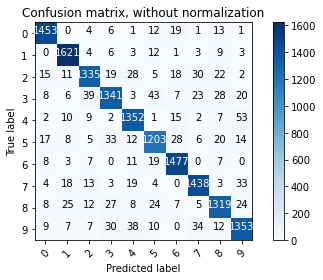

In [29]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
class_names = [str(idx) for idx in range(10)]
cnf_matrix = confusion_matrix(expected_outputs, predicted_outputs)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()